In [8]:
import os
import datetime
import matplotlib.pyplot as plt

In [9]:
os.chdir(r"D:\B2B_Git_Instance\Face-Mask-Detection\dataset")

In [10]:
num_class = len(os.listdir()[1:])

In [11]:
!pip install split-folders

In [12]:
import splitfolders

In [13]:
# credits: https://pypi.org/project/split-folders/ , https://stackoverflow.com/questions/57394135/split-image-dataset-into-train-test-datasets

In [14]:
splitfolders.ratio(input=os.getcwd(), output=r"D:\B2B_Git_Instance\Face-Mask-Detection", ratio = (0.8,0.2))

In [15]:
train = r"D:\B2B_Git_Instance\Face-Mask-Detection\train"
val = r"D:\B2B_Git_Instance\Face-Mask-Detection\val"

In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
img_rows, img_cols = 224, 224

In [18]:
mobilenet = MobileNetV2(input_shape = (img_rows, img_cols, 3), include_top = False)

In [19]:
for layer in mobilenet.layers:
    layer.trainable = False

In [20]:
def addTopLayers(pretrained_model, num_classes):
    top_layer = pretrained_model.output
    top_layer = AveragePooling2D(pool_size=(7, 7))(top_layer)
    top_layer = Flatten(name="flatten")(top_layer)
    top_layer = Dense(128, activation = 'relu')(top_layer)
    top_layer = Dropout(0.5)(top_layer)
    top_layer = Dense(num_classes, activation = 'softmax')(top_layer)
    return top_layer

In [21]:
full_model = addTopLayers(mobilenet, num_class)

In [22]:
model = Model(inputs = mobilenet.input, outputs = full_model)
model.compile(loss = 'binary_crossentropy', metrics = 'accuracy', optimizer = 'adam')

In [23]:
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [24]:
img_gen = ImageDataGenerator(
rotation_range=20,
zoom_range=0.15,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.15,
horizontal_flip=True,
fill_mode="nearest", rescale=1./255)

In [25]:
train_batch = img_gen.flow_from_directory(directory = train, target_size = (img_rows, img_cols), batch_size=32)
test_batch = img_gen.flow_from_directory(directory = val, target_size = (img_rows, img_cols), shuffle = False, batch_size=32)

Found 3066 images belonging to 2 classes.
Found 767 images belonging to 2 classes.


In [26]:
test_batch.class_indices

{'with_mask': 0, 'without_mask': 1}

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [20]:
early_stop = EarlyStopping(monitor = 'accuracy', min_delta = 0.5, patience = 5, mode = 'max', baseline = 0.5 )
reduce_lr = ReduceLROnPlateau(monitor = 'accuracy')
model.fit(train_batch, epochs = 10, validation_data = test_batch, callbacks = [early_stop, reduce_lr], workers = 3)

Epoch 1/10
63/96 [==================>...........] - ETA: 5s - loss: 0.1872 - accuracy: 0.9224

c:\programdata\anaconda3\envs\tf_gpu\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


96/96 [==============================] - 25s 262ms/step - loss: 0.1486 - accuracy: 0.9410 - val_loss: 0.0668 - val_accuracy: 0.9778
Epoch 2/10
96/96 [==============================] - 19s 203ms/step - loss: 0.0736 - accuracy: 0.9752 - val_loss: 0.0469 - val_accuracy: 0.9804
Epoch 3/10
96/96 [==============================] - 21s 215ms/step - loss: 0.0472 - accuracy: 0.9850 - val_loss: 0.0476 - val_accuracy: 0.9804
Epoch 4/10
96/96 [==============================] - 19s 197ms/step - loss: 0.0493 - accuracy: 0.9824 - val_loss: 0.0509 - val_accuracy: 0.9791
Epoch 5/10
96/96 [==============================] - 19s 199ms/step - loss: 0.0353 - accuracy: 0.9879 - val_loss: 0.0494 - val_accuracy: 0.9870


In [21]:
import pandas as pd

In [22]:
history = pd.DataFrame(model.history.history)

<AxesSubplot:>

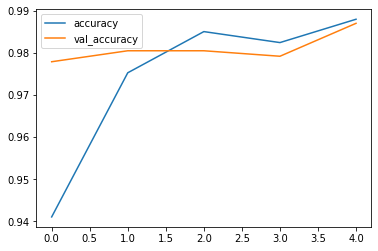

In [23]:
history[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

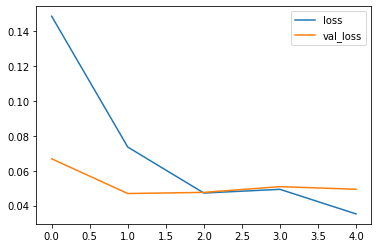

In [24]:
history[['loss','val_loss']].plot()

In [25]:
import numpy as np
pred = np.argmax(model.predict(test_batch), axis = -1)
from sklearn.metrics import classification_report
print(classification_report(test_batch.classes, pred))


c:\programdata\anaconda3\envs\tf_gpu\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       383
           1       0.99      0.98      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [26]:
model.save('face_mask_detector.h5')


In [1]:
from tensorflow.keras.models import load_model

In [2]:
model = load_model(r"D:\B2B_Git_Instance\Face-Mask-Detection\mask_detector.model")

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
font = cv2.FONT_HERSHEY_SIMPLEX 

In [13]:
face_cascade = cv2.CascadeClassifier(r"D:\B2B_Git_Instance\Face-Mask-Detection\haarcascade_frontalface_default.xml")


In [14]:
def detect_face(img):
    img_cpy = img.copy()
    face_rect = face_cascade.detectMultiScale(img_cpy, scaleFactor = 1.2, minNeighbors = 5)
    for (x,y,w,h) in face_rect:
        cv2.rectangle(img_cpy, pt1 = (x,y), pt2 = (x+w, y+h), color = (255,255,255), thickness = 1)
        crop_img = img_cpy[y:y+h,x:x+w]
        cv2.resize(crop_img,(224,224),3, interpolation = cv2.INTER_NEAREST)
#         print(crop_img.shape)
        if crop_img.shape[:1] >= (224,224):
            crop_img = np.expand_dims(crop_img, axis = 0)
            if np.argmax(model.predict(crop_img), axis=1) == [1]:
                print("W/O")
            else:
                print("With")
            
        else:
            pass
    return img_cpy

In [15]:
import cv2
cap = cv2.VideoCapture(0) # video capture object
while True:
    ret, frame = cap.read(0) # capture the frame
    frame = detect_face(frame)
    cv2.imshow('frame',frame) # show the video feed that is being captured. Videos are just images played in a sequence
    if cv2.waitKey(1) & 0xFF == 27: # break mechanism
        break
cap.release() # release the capture obj        
cv2.destroyAllWindows()

W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O


In [4]:
import cv2
import sys
import warnings
warnings.filterwarnings("ignore")
def ask_for_tracker():
    
    print("Welcome! What Tracker API would you like to use?")
    print("1: BOOSTING")
    print("2: MIL")
    print("3: KCF")
    print("4: TLD")
    print("5: MEDIANFLOW")
    print("6: Exit")
    choice = input()
    
    if choice == '1':
        tracker = cv2.TrackerBoosting_create()
    if choice == '2':
        tracker = cv2.TrackerMIL_create()
    if choice == '3':
        tracker = cv2.TrackerKCF_create()
    if choice == '4':
        tracker = cv2.TrackerTLD_create()
    if choice == '5':
        tracker = cv2.TrackerMedianFlow_create()
    if choice == 'q' or choice == 'Q' or choice == '6':
        sys.exit()

    return tracker

In [5]:
tracker = ask_for_tracker()
str(tracker).split()[0][1:]

Welcome! What Tracker API would you like to use?
1: BOOSTING
2: MIL
3: KCF
4: TLD
5: MEDIANFLOW
6: Exit
1


'TrackerBoosting'

In [6]:
tracker_name = str(tracker).split()[0][1:]

# Read video
cap = cv2.VideoCapture(0)

# Read first frame.
ret, frame = cap.read()


# Special function allows us to draw on the very first frame our desired ROI
roi = cv2.selectROI(frame, False)

# Initialize tracker with first frame and bounding box
ret = tracker.init(frame, roi)

while True:
    # Read a new frame
    ret, frame = cap.read()
    
    
    # Update tracker
    success, roi = tracker.update(frame)
    
    # roi variable is a tuple of 4 floats
    # We need each value and we need them as integers
    (x,y,w,h) = tuple(map(int,roi))
    
    # Draw Rectangle as Tracker moves
    if success:
        # Tracking success
        p1 = (x, y)
        p2 = (x+w, y+h)
        cv2.rectangle(frame, p1, p2, (0,255,0), 3)
        crop_img = frame[y:y+h,x:x+w]
        cv2.resize(crop_img,(224,224),3, interpolation = cv2.INTER_NEAREST)
        if crop_img.shape[:1] >= (224,224):
            crop_img = np.expand_dims(crop_img, axis = 0)
            if np.argmax(model.predict(crop_img), axis=1) == [1]:
                print("W/O")
            else:
                print("With")

        else:
            pass
        
    else :
        # Tracking failure
        cv2.putText(frame, "Failure to Detect Tracking!!", (100,200), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,255),3)

    # Display tracker type on frame
    cv2.putText(frame, tracker_name, (20,400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),3);

    # Display result
    cv2.imshow(tracker_name, frame)

    # Exit if ESC pressed
    k = cv2.waitKey(1) & 0xff
    if k == 27 : 
        break
        
cap.release()
cv2.destroyAllWindows()

W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
With
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
With
W/O
W/O
With
With
W/O
With
W/O
W/O
With
W/O
With
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
With
W/O
W/O
With
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
With
W/O
W/O
W/O
W/O
W/O
With
With
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
With
W/O
W/O
With
With
W/O
W/O
W/O
W/O
W/O
W/O
With
W/O
W/O
W/O
W/O
With
W/O
With
With
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
With
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
With
W/O
With
With
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
With
With
W/O
W/O
With
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
W/O
With
W/O
W/O
W/O
W/O
With
With
W/O
W/O
With
With
With
With
W/O
With
W/O
With
With
With
W/O
With
With
With
With
With
With
W/O
W/O
With
W/O
